In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from scipy import interpolate
from symbeam import beam
from sympy.abc import E, I, L, M, P, q, x

import ajf_plts

plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

In [2]:
E = 30e9
I = 1.0
L = 20.0
P = 1e3

x_load = np.linspace(0.0, L, 21)

In [3]:
def assemble_beam(L, E, I0, xr, la, delta, depth):
    print()
    print(f"xr:{xr} la:{la} L:{L}")

    b = beam(L)

    b.set_young(0, L, E)

    if delta == 0.0:
        Ir = I0
    else:
        lc = 1.5 * depth
        Ir = I0 * (1.0 - (lc / la) * (1.0 - (1.0 - delta) ** 3.0))

    xr_left = xr - 0.5 * la
    if xr_left < 0.0:
        print("Error 1")
        exit(-1)

    xr_right = xr + 0.5 * la
    if xr_right > L:
        print("Error 2")
        exit(-1)

    if xr_left > 0.0:
        b.set_inertia(0, xr_left, I0)

    b.set_inertia(xr_left, xr_right, Ir)

    if xr_right < L:
        b.set_inertia(xr_right, L, I0)

    print(f"xr_left:{xr_left} xr_right:{xr_right} Ir:{Ir}")

    b.add_support(0, "pin")
    b.add_support(L, "roller")

    return b


def compute_RILs(L, E, I, xr=1.0, lr=0.5, delta=0.0, depth=1.0):
    P = -1e3

    LHS = []
    RHS = []

    b = assemble_beam(L=L, E=E, I0=I, xr=xr, la=lr, delta=delta, depth=depth)

    for step in x_load:
        b.add_point_load(step, P)
        b.solve(output=False)
        LHS.append(b.segments[0].rotation.subs(x, 0.0))
        RHS.append(b.segments[-1].rotation.subs(x, L))
        # reset beam so we can move point load
        b.point_load_list = []
        b.points = []
        b.segments = []
    return LHS, RHS


x_dam = 0.333 * L
l_dam = 0.1 * L

LHS_H, RHS_H = compute_RILs(L, E, I, xr=x_dam, lr=l_dam, delta=0.0)
LHS_D1, RHS_D1 = compute_RILs(L, E, I, xr=x_dam, lr=l_dam, delta=0.1)
LHS_D2, RHS_D2 = compute_RILs(L, E, I, xr=x_dam, lr=l_dam, delta=0.2)


xr:6.66 la:2.0 L:20.0
xr_left:5.66 xr_right:7.66 Ir:1.0

xr:6.66 la:2.0 L:20.0
xr_left:5.66 xr_right:7.66 Ir:0.7967500000000001

xr:6.66 la:2.0 L:20.0
xr_left:5.66 xr_right:7.66 Ir:0.6340000000000001


In [4]:
def fit_IL(x_vals, IL_vals, degree=3):
    return interpolate.CubicSpline(x_vals, IL_vals)


LHS_H_fit = fit_IL(x_load, LHS_H)
RHS_H_fit = fit_IL(x_load, RHS_H)

LHS_D1_fit = fit_IL(x_load, LHS_D1)
RHS_D1_fit = fit_IL(x_load, RHS_D1)

LHS_D2_fit = fit_IL(x_load, LHS_D2)
RHS_D2_fit = fit_IL(x_load, RHS_D2)

Pos: 0.42211055276381915 ILmax:-0.855332612829727
Pos: 0.41206030150753775 ILmax:-0.8991564324925958
Pos: 0.40201005025125636 ILmax:-0.9555284283339404
Pos: 0.577889447236181 ILmax:0.8553326128297276
Pos: 0.5728643216080402 ILmax:0.8714876294836719
Pos: 0.5678391959798995 ILmax:0.8921505830463624


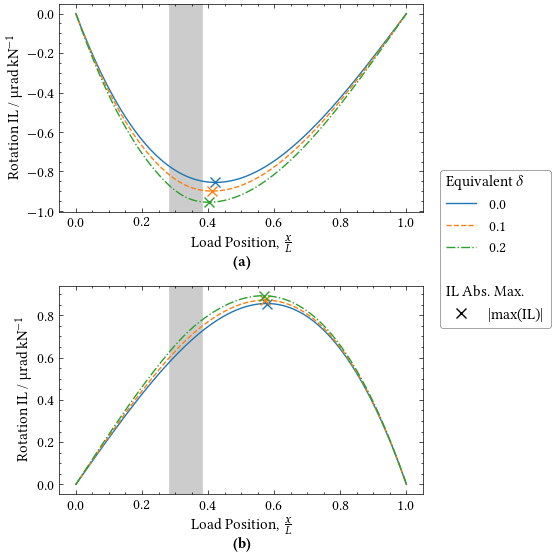

In [5]:
%matplotlib widget

x_plot = np.linspace(0, L, 200)

marker_props = dict(markersize=2.5, markevery=0.15)
# lhs_marker = dict(marker='o')
# rhs_marker = dict(marker='^')
lhs_marker = dict(marker="")
rhs_marker = dict(marker="")
max_marker = dict(marker="x", markersize=7.0)

# find maxima/minima
def annotate_abs_max(ax, fit, color="k"):
    ind = np.argmax(np.abs(fit(x_plot)))
    print(f"Pos: {(x_plot/L)[ind]} ILmax:{fit(x_plot)[ind]*1e6}")
    ax.plot((x_plot / L)[ind], fit(x_plot)[ind] * 1e6, color=color, **max_marker)


fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 2.5 * ajf_plts.fig_height_inches),
    nrows=2,
    ncols=1,
)

for IL, c, ls in zip(
    [LHS_H_fit, LHS_D1_fit, LHS_D2_fit], ["C0", "C1", "C2"], ["-", "--", "-."]
):
    axes[0].plot(x_plot / L, IL(x_plot) * 1e6, c=c, ls=ls)
    annotate_abs_max(axes[0], IL, color=c)

for IL, c, ls in zip(
    [RHS_H_fit, RHS_D1_fit, RHS_D2_fit], ["C0", "C1", "C2"], ["-", "--", "-."]
):
    axes[1].plot(x_plot / L, IL(x_plot) * 1e6, c=c, ls=ls)
    annotate_abs_max(axes[1], IL, color=c)


for ax in axes:
    ax.axvspan(
        (x_dam - 0.5 * l_dam) / L, (x_dam + 0.5 * l_dam) / L, color="0.8", zorder=-100
    )
    ax.set_xlabel(r"Load Position, $\frac{x}{L}$")
    ax.set_ylabel(r"Rotation IL / $\unit{\micro\radian\per\kilo\newton}$")


class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mpl.text.Text(x0, y0, orig_handle)
        handlebox.add_artist(title)
        return title


custom_lines = [
    r"Equivalent $\delta$",
    mpl.lines.Line2D([0], [0], color="C0", ls="-", label="0.0"),
    mpl.lines.Line2D([0], [0], color="C1", ls="--", label="0.1"),
    mpl.lines.Line2D([0], [0], color="C2", ls="-.", label="0.2"),
    #                '',
    #                r'End of span',
    #                mpl.lines.Line2D([0], [0], color='k', ls='-', **lhs_marker, label='LHS'),
    #                mpl.lines.Line2D([0], [0], color='k', ls='-', **rhs_marker, label='RHS'),
    "",
    r"IL Abs. Max.",
    mpl.lines.Line2D([0], [0], color="k", ls="", **max_marker),
]

ax_fake = fig.add_subplot(111)
ax_fake.set_axis_off()
ax_fake.legend(
    custom_lines,
    [
        "",
        "0.0",
        "0.1",
        "0.2",
        # '', '', 'LHS', 'RHS',
        "",
        "",
        r"$\lvert\text{max}(\text{IL})\rvert$",
    ],
    handler_map={str: LegendTitle()},
    loc="center left",
    bbox_to_anchor=(1.025, 0.5),
)


ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, "figRILwThirdDamage.pdf")

In [6]:
xr = 0.333 * L
la = 0.075 * L

In [7]:
def assemble_beam(L, E, I0, xr, la, delta, depth):
    print()
    print(f"xr:{xr} la:{la} L:{L}")

    b = beam(L)

    b.set_young(0, L, E)

    if delta == 0.0:
        Ir = I0
    else:
        lc = 1.5 * depth
        Ir = I0 * (1.0 - (lc / la) * (1.0 - (1.0 - delta) ** 3.0))

    xr_left = xr - 0.5 * la
    if xr_left < 0.0:
        print("Error 1")
        exit(-1)

    xr_right = xr + 0.5 * la
    if xr_right > L:
        print("Error 2")
        exit(-1)

    if xr_left > 0.0:
        b.set_inertia(0, xr_left, I0)

    b.set_inertia(xr_left, xr_right, Ir)

    if xr_right < L:
        b.set_inertia(xr_right, L, I0)

    print(f"xr_left:{xr_left} xr_right:{xr_right} Ir:{Ir}")

    b.add_support(0, "pin")
    b.add_support(L, "roller")

    return b


def compute_RILs(L, E, I, xr, delta, depth=1.0):
    P = 1e3

    LHS = []
    RHS = []

    b = assemble_beam(L=L, E=E, I0=I, xr=xr, la=la, delta=delta, depth=depth)

    for step in x_load:
        b.add_point_load(step, -P)
        b.solve(output=False)
        LHS.append(b.segments[0].rotation.subs(x, 0.0))
        RHS.append(b.segments[-1].rotation.subs(x, L))
        # reset beam so we can move point load
        b.point_load_list = []
        b.points = []
        b.segments = []
    return LHS, RHS


LHS_H, RHS_H = compute_RILs(L, E, I, xr, delta=0.0)
LHS_D1, RHS_D1 = compute_RILs(L, E, I, xr, delta=0.1)
LHS_D2, RHS_D2 = compute_RILs(L, E, I, xr, delta=0.2)


xr:6.66 la:1.5 L:20.0
xr_left:5.91 xr_right:7.41 Ir:1.0

xr:6.66 la:1.5 L:20.0
xr_left:5.91 xr_right:7.41 Ir:0.7290000000000001

xr:6.66 la:1.5 L:20.0
xr_left:5.91 xr_right:7.41 Ir:0.5120000000000001


In [8]:
def fit_IL(x_vals, IL_vals, degree=3):
    return interpolate.CubicSpline(x_vals, IL_vals)


LHS_H_fit = fit_IL(x_load, LHS_H)
RHS_H_fit = fit_IL(x_load, RHS_H)

LHS_D1_fit = fit_IL(x_load, LHS_D1)
RHS_D1_fit = fit_IL(x_load, RHS_D1)

LHS_D2_fit = fit_IL(x_load, LHS_D2)
RHS_D2_fit = fit_IL(x_load, RHS_D2)

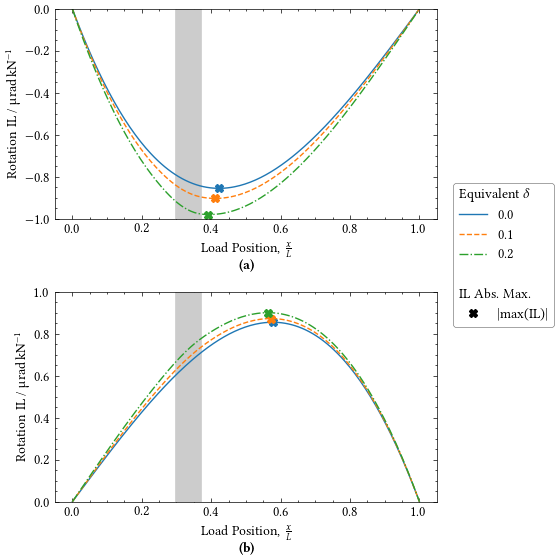

In [9]:
%matplotlib widget

x_plot = np.linspace(0, L, 200)

marker_props = dict(markersize=2.5, markevery=0.15)
# lhs_marker = dict(marker='o')
# rhs_marker = dict(marker='^')
lhs_marker = dict(marker="")
rhs_marker = dict(marker="")

# find maxima/minima
def annotate_abs_max(ax, fit, color="k"):
    ind = np.argmax(np.abs(fit(x_plot)))
    ax.plot(
        (x_plot / L)[ind],
        fit(x_plot)[ind] * 1e6,
        color=color,
        marker="X",
        markersize=6.0,
    )


fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 2.5 * ajf_plts.fig_height_inches),
    nrows=2,
    ncols=1,
)

for IL, c, ls in zip(
    [LHS_H_fit, LHS_D1_fit, LHS_D2_fit], ["C0", "C1", "C2"], ["-", "--", "-."]
):
    axes[0].plot(x_plot / L, IL(x_plot) * 1e6, c=c, ls=ls)
    annotate_abs_max(axes[0], IL, color=c)

for IL, c, ls in zip(
    [RHS_H_fit, RHS_D1_fit, RHS_D2_fit], ["C0", "C1", "C2"], ["-", "--", "-."]
):
    axes[1].plot(x_plot / L, IL(x_plot) * 1e6, c=c, ls=ls)
    annotate_abs_max(axes[1], IL, color=c)


for ax in axes:
    ax.axvspan((xr - 0.5 * la) / L, (xr + 0.5 * la) / L, color="0.8")
    ax.set_xlabel(r"Load Position, $\frac{x}{L}$")
    ax.set_ylabel(r"Rotation IL / $\unit{\micro\radian\per\kilo\newton}$")

axes[0].set_ylim([-1.0, 0.0])
axes[1].set_ylim([0.0, 1.0])


class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mpl.text.Text(x0, y0, orig_handle)
        handlebox.add_artist(title)
        return title


custom_lines = [
    r"Equivalent $\delta$",
    mpl.lines.Line2D([0], [0], color="C0", ls="-", label="0.0"),
    mpl.lines.Line2D([0], [0], color="C1", ls="--", label="0.1"),
    mpl.lines.Line2D([0], [0], color="C2", ls="-.", label="0.2"),
    "",
    r"IL Abs. Max.",
    mpl.lines.Line2D([0], [0], color="k", ls="", marker="X"),
]

ax_fake = fig.add_subplot(111)
ax_fake.set_axis_off()
ax_fake.legend(
    custom_lines,
    [
        "",
        "0.0",
        "0.1",
        "0.2",
        # '', '', 'LHS', 'RHS',
        "",
        "",
        r"$\lvert\text{max}(\text{IL})\rvert$",
    ],
    handler_map={str: LegendTitle()},
    loc="center left",
    bbox_to_anchor=(1.025, 0.5),
)


ajf_plts.caption_axes(axes)
fig.tight_layout()

NameError: name 'LHS_D_fit' is not defined

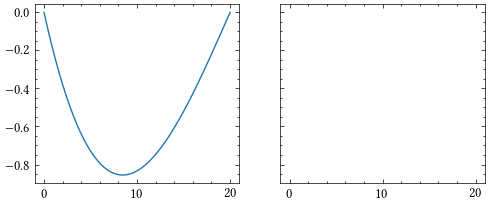

In [10]:
fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches),
    ncols=2,
    nrows=1,
    sharex=True,
    sharey=True,
)

axes[0].plot(x_plot, LHS_H_fit(x_plot) * 1e6)
axes[0].plot(x_plot, LHS_D_fit(x_plot) * 1e6)

axes[1].plot(x_plot, RHS_H_fit(x_plot) * 1e6)
axes[1].plot(x_plot, RHS_D_fit(x_plot) * 1e6)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()

for i, isegment in enumerate(new_beam.segments):
    rotation_plot = isegment.rotation
    x_start_plot = isegment.x_start
    x_end_plot = isegment.x_end

    variables_rotation = rotation_plot.free_symbols
    variables_rotation.discard(x)
    variables_x_start = x_start_plot.free_symbols
    variables_x_start.discard(x)
    variables_x_end = x_end_plot.free_symbols
    variables_x_end.discard(x)

    for ivariable in variables_rotation:
        rotation_plot = rotation_plot.subs({ivariable: 1})
    for ivariable in variables_x_start:
        x_start_plot = x_start_plot.subs({ivariable: 1})
    for ivariable in variables_x_end:
        x_end_plot = x_end_plot.subs({ivariable: 1})

    # Numerical plotting x variable
    x_plot = np.linspace(float(x_start_plot), float(x_end_plot), num=100, endpoint=True)

    ax.plot(x_plot, np.vectorize(sym.lambdify(x, rotation_plot))(x_plot), c="k")

In [ ]:
new_beam.points

In [ ]:
b.segments[0].rotation.subs(x, 0.0)

In [ ]:
b.

In [ ]:
b.length.is_number

In [ ]:
def calc_slope(b):
    rotation_plot = isegment.rotation
    x_start_plot = isegment.x_start
    x_end_plot = isegment.x_end

    variables_rotation = rotation_plot.free_symbols
    variables_rotation.discard(x)
    variables_x_start = x_start_plot.free_symbols
    variables_x_start.discard(x)
    variables_x_end = x_end_plot.free_symbols
    variables_x_end.discard(x)

    for ivariable in variables_rotation:
        rotation_plot = rotation_plot.subs({ivariable: 1})
    for ivariable in variables_x_start:
        x_start_plot = x_start_plot.subs({ivariable: 1})
    for ivariable in variables_x_end:
        x_end_plot = x_end_plot.subs({ivariable: 1})

    # Numerical plotting x variable
    x_plot = np.linspace(float(x_start_plot), float(x_end_plot), num=100, endpoint=True)

    ax.plot(x_plot, np.vectorize(sym.lambdify(x, rotation_plot))(x_plot), c="k")

In [ ]:
for i, isegment in enumerate(new_beam.segments):
    rotation_plot = isegment.rotation
    x_start_plot = isegment.x_start
    x_end_plot = isegment.x_end

    variables_rotation = rotation_plot.free_symbols
    variables_rotation.discard(x)
    variables_x_start = x_start_plot.free_symbols
    variables_x_start.discard(x)
    variables_x_end = x_end_plot.free_symbols
    variables_x_end.discard(x)

    for ivariable in variables_rotation:
        rotation_plot = rotation_plot.subs({ivariable: 1})
    for ivariable in variables_x_start:
        x_start_plot = x_start_plot.subs({ivariable: 1})
    for ivariable in variables_x_end:
        x_end_plot = x_end_plot.subs({ivariable: 1})

    # Numerical plotting x variable
    x_plot = np.linspace(float(x_start_plot), float(x_end_plot), num=100, endpoint=True)

    ax.plot(x_plot, np.vectorize(sym.lambdify(x, rotation_plot))(x_plot), c="k")

In [ ]:
isegment.x_end

In [ ]:
new_beam.point_load_list = []

In [ ]:
for seg in new_beam.segments:
    sym.plotting.plot(seg.rotation)